In [2]:
from typing import List
import numpy as np


def read_hands(file: str):
    poses: List[np.ndarray] = []
    pose_size = 20 * 3  # number of floats
    with open(file, "rb") as f:
        data = f.read()
        total_floats = len(data) // 4  # float32 = 4 bytes
        if total_floats % pose_size != 0:
            raise ValueError("File size is not a multiple of single pose size")
        array = np.frombuffer(data, dtype=np.float32)
        for i in range(0, total_floats, pose_size):
            pose = array[i : i + pose_size].reshape((20, 3))
            poses.append(pose)
    return np.stack(poses, axis=0)

In [3]:
import plotly.graph_objects as go
import numpy as np
import torch


def plot_3d_hand(landmarks: torch.Tensor | np.ndarray):
    if isinstance(landmarks, torch.Tensor):
        landmarks = landmarks.detach().cpu().numpy()

    fig = go.Figure()
    n_pts = landmarks.shape[0]
    labels = [str(i) for i in range(n_pts)]

    # Plot landmarks as 3D markers + text labels
    fig.add_trace(
        go.Scatter3d(
            x=landmarks[:, 0],
            y=landmarks[:, 1],
            z=landmarks[:, 2],
            mode="markers+text",
            marker=dict(size=4, color="blue"),
            text=labels,
            textposition="top center",
            textfont=dict(size=8, color="black"),
            name="Landmarks",
        )
    )

    connections = [
        (0, 1),
        (1, 2),
        (2, 3),  # Thumb
        (0, 4),
        (4, 5),
        (5, 6),
        (6, 7),  # Index
        (0, 8),
        (8, 9),
        (9, 10),
        (10, 11),  # Middle
        (0, 12),
        (12, 13),
        (13, 14),
        (14, 15),  # Ring
        (0, 16),
        (16, 17),
        (17, 18),
        (18, 19),  # Pinky
        # Palm
        (1, 4),
        (4, 8),
        (8, 12),
        (12, 16),
    ]

    # Plot connections (lines) between the landmarks
    for i, j in connections:
        fig.add_trace(
            go.Scatter3d(
                x=[landmarks[i, 0], landmarks[j, 0]],
                y=[landmarks[i, 1], landmarks[j, 1]],
                z=[landmarks[i, 2], landmarks[j, 2]],
                mode="lines",
                line=dict(color="black", width=2),
                showlegend=False,
            )
        )

    fig.update_layout(
        scene=dict(
            xaxis_title="X",
            yaxis_title="Y",
            zaxis_title="Z",
            xaxis=dict(autorange="reversed"),  # This line inverts the X axis
        ),
        title="3D Hand Pose with Point Labels",
        margin=dict(l=0, r=0, b=0, t=30),
    )

    fig.show()

In [4]:
import torch

# Bone connections
BONE_CONNECTIONS = [
    (0, 1),
    (1, 2),
    (2, 3),  # Thumb
    (0, 4),
    (4, 5),
    (5, 6),
    (6, 7),  # Index
    (0, 8),
    (8, 9),
    (9, 10),
    (10, 11),  # Middle
    (0, 12),
    (12, 13),
    (13, 14),
    (14, 15),  # Ring
    (0, 16),
    (16, 17),
    (17, 18),
    (18, 19),  # Pinky
]

# Desired bone lengths
BONE_LENGTHS = {
    (0, 1): 7.0,
    (1, 2): 3.5,
    (2, 3): 2.5,  # Thumb
    (0, 4): 9.0,
    (4, 5): 4.0,
    (5, 6): 2.5,
    (6, 7): 2.0,  # Index
    (0, 8): 9.0,
    (8, 9): 5.0,
    (9, 10): 3.0,
    (10, 11): 2.0,  # Middle
    (0, 12): 8.5,
    (12, 13): 5.0,
    (13, 14): 3.0,
    (14, 15): 2.0,  # Ring
    (0, 16): 8.0,
    (16, 17): 4.0,
    (17, 18): 2.5,
    (18, 19): 2.0,  # Pinky
}


def fix_hand_landmarks_anatomy(joints: torch.Tensor) -> torch.Tensor:
    """
    Normalize bone lengths of hand landmarks.
    Input: joints - (B, 20, 3)
    Output: (B, 20, 3) with normalized bone lengths
    """
    fixed = joints.clone()

    for p, c in BONE_CONNECTIONS:
        vec = joints[:, c] - joints[:, p]  # (B, 3)
        length = torch.norm(vec, dim=-1, keepdim=True)  # (B, 1)
        direction = torch.where(
            length > 0, vec / length, torch.zeros_like(vec)
        )  # (B, 3)
        target_length = BONE_LENGTHS[(p, c)]
        fixed[:, c] = fixed[:, p] + direction * target_length

    return fixed

In [5]:
import numpy as np
import torch


def rotation_matrix_from_vectors(
    vec1: torch.Tensor,
    vec2: torch.Tensor,
    eps: float = 1e-6,
) -> torch.Tensor:
    a = vec1 / vec1.norm()
    b = vec2 / vec2.norm()
    v = torch.cross(a, b, dim=-1)
    if v.norm() < eps:
        return torch.eye(3, dtype=vec1.dtype, device=vec1.device)
    c = torch.dot(a, b)
    s = v.norm()
    K = torch.tensor(
        [[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]],
        dtype=vec1.dtype,
        device=vec1.device,
    )
    R = torch.eye(3, dtype=vec1.dtype, device=vec1.device)
    return R + K + K @ K * ((1 - c) / (s * s))


def normalize_hand(
    hand_3d_points: torch.Tensor | np.ndarray,
    whrist_base: int = 0,
    middle_finger_inner_bone: int = 8,
    point_finger_inner_bone: int = 4,
    eps: float = 1e-6,
) -> torch.Tensor:
    """
    Normalize one hand (L,3) or a batch of hands (B, L, 3):
      1. translate so point `whrist_base` is at the origin
      2. rotate so `middle_finger_inner_bone` aligns with +Y
      3. scale so that vector to `middle_finger_inner_bone` has length 1
      4. rotate around Y so `point_finger_inner_bone` lies in the +Z half-plane
    Returns same shape as input.
    """
    if not isinstance(hand_3d_points, torch.Tensor):
        hand_3d_points = torch.tensor(hand_3d_points, dtype=torch.float32)

    # if batch of hands, just loop
    if hand_3d_points.dim() == 3:
        B, L, _ = hand_3d_points.shape
        normalized = torch.empty_like(hand_3d_points)
        for b in range(B):
            # recursive call on each (L,3)
            normalized[b] = normalize_hand(
                hand_3d_points[b],
                whrist_base,
                middle_finger_inner_bone,
                point_finger_inner_bone,
                eps,
            )
        return normalized

    # --- below is the original single‑hand logic for shape (L,3) ---
    device, dtype = hand_3d_points.device, hand_3d_points.dtype

    # 1) translate so wrist base → origin
    T = -hand_3d_points[whrist_base]
    hand = hand_3d_points + T

    # 2) rotate so that middle finger inner bone aligns with +Y
    target_y = torch.tensor([0, 1, 0], dtype=dtype, device=device)
    R1 = rotation_matrix_from_vectors(hand[middle_finger_inner_bone], target_y, eps=eps)
    hand = hand @ R1.T

    # 3) scale so middle‐finger inner bone length → 1
    hand = hand / (hand[middle_finger_inner_bone][1] + eps)

    # 4) rotate around Y so the point finger inner bone lies in +Z half-plane
    v = hand[point_finger_inner_bone]
    xz = torch.stack([v[0], v[2]])
    norm_xz = xz.norm()
    if norm_xz >= eps:
        sinA, cosA = xz[0] / norm_xz, xz[1] / norm_xz
        R2 = torch.tensor(
            [[cosA, 0.0, -sinA], [0.0, 1.0, 0.0], [sinA, 0.0, cosA]],
            dtype=dtype,
            device=device,
        )
        hand = hand @ R2.T

    return hand

In [6]:
def rot(
    v: torch.Tensor,
    p: torch.Tensor,
    alpha: torch.Tensor,
    beta: torch.Tensor,
):
    """
    Batched rotation function.

    v, p: (B, 3) tensors representing vector and the first axis of rotation
    alpha, beta: (B,) tensors representing angles to use for rotation
    """
    sinA, cosA = torch.sin(alpha).unsqueeze(-1), torch.cos(alpha).unsqueeze(-1)
    sinB, cosB = torch.sin(beta).unsqueeze(-1), torch.cos(beta).unsqueeze(-1)

    q = torch.cross(v, p, dim=1)

    v_hat = q * sinA + v * cosA * cosB + p * sinB
    p_hat = p * cosB - v * sinB

    return v_hat, p_hat


def hand_landmarks_by_angles(
    angles: torch.Tensor,
    morphology: torch.Tensor,
):
    """
    angles: (B, 20)
    morphology: (5, 7) - not batched
    Returns: (B, 20, 3)
    """
    B = angles.shape[0]
    landmarks = torch.zeros(B, 20, 3, dtype=angles.dtype, device=angles.device)

    angles = angles.unflatten(dim=-1, sizes=(5, 4))

    # Write morphological const points
    for i in range(1, 5):
        landmarks[:, 4 * i, :] = morphology[i, 3:6]

    V = torch.tensor([0, 1, 0], dtype=angles.dtype, device=angles.device).expand(B, 3)
    P = torch.tensor([-1, 0, 0], dtype=angles.dtype, device=angles.device).expand(B, 3)

    for finger_index, (morph, local_angles) in enumerate(
        zip(morphology, angles.transpose(0, 1))
    ):
        base_idx = finger_index * 4
        bone_lengths = morph[0:3]
        joint = morph[3:6].expand(B, 3).clone()
        gamma = morph[6]

        a0, b0, a2, a3 = local_angles.unbind(dim=-1)
        chain_angles = torch.stack(
            [
                torch.stack([a0, b0], dim=-1),
                torch.stack([a2, torch.zeros_like(a2)], dim=-1),
                torch.stack([a3, torch.zeros_like(a3)], dim=-1),
            ],
            dim=1,
        )  # (B, 3, 2)

        v = torch.nn.functional.normalize(joint, dim=-1)

        # Get p perpendicular to v
        sinB = torch.sum(v * P, dim=-1, keepdim=True)  # (B, 1)
        cosB = torch.sqrt(1.0 - sinB**2)  # (B, 1)
        p = P * cosB - V * sinB  # (B, 3)

        # Rotate p around v according to parameter gamma
        sinG, cosG = torch.sin(gamma), torch.cos(gamma)
        p = p * cosG + torch.cross(p, v, dim=-1) * sinG

        # Iterate over the chain and write the 3d points
        for j in range(3):
            l = bone_lengths[j]
            alpha, beta = chain_angles[:, j, 0], chain_angles[:, j, 1]
            v, p = rot(v, p, alpha, beta)
            joint = joint + v * l
            landmarks[:, base_idx + j + 1, :] = joint

    return landmarks

In [7]:
def irot(
    v: torch.Tensor,
    p: torch.Tensor,
    v_hat: torch.Tensor,
):
    """
    Batched inverse rotation function.

    v, p: (B, 3) tensors representing the original vector and rotation axis
    v_hat: (B, 3) the rotated vector

    Returns:
    alpha, beta: (B,) tensors representing rotation angles
    p_hat: (B, 3) new axis of rotation after rotating v by alpha, beta to v_hat
    """
    # Cross product axis
    q = torch.cross(v, p, dim=-1)

    # Compute sinA and sinB
    sinA = (v_hat * q).sum(dim=-1).clamp(-1 + 1e-6, 1 - 1e-6)
    sinB = (v_hat * p).sum(dim=-1).clamp(-1 + 1e-6, 1 - 1e-6)

    # Alpha is angle around q (torsion), beta is angle between v and v_hat in plane with p
    alpha = torch.asin(sinA)
    beta = torch.asin(sinB)

    cosB = (1 - sinB**2).clamp(min=1e-7).sqrt()
    p_hat = p * cosB.unsqueeze(-1) - v * sinB.unsqueeze(-1)

    return alpha, beta, p_hat


def inverse_hand_angles_by_landmarks(
    landmarks: torch.Tensor,
    morphology: torch.Tensor,
) -> torch.Tensor:
    """
    landmarks: (B, 20, 3) - known hand landmarks in 3D space
    morphology: (5, 7) - hand morphology (not batched)

    Returns:
    angles: (B, 20) - recovered joint angles
    """
    B = landmarks.shape[0]
    angles = torch.zeros(B, 5, 4, dtype=landmarks.dtype, device=landmarks.device)

    V = torch.tensor([0, 1, 0], dtype=landmarks.dtype, device=landmarks.device).expand(
        B, 3
    )
    P = torch.tensor([-1, 0, 0], dtype=landmarks.dtype, device=landmarks.device).expand(
        B, 3
    )

    for i, morph in enumerate(morphology):
        joint = morph[3:6].expand(B, 3).clone()
        gamma = morph[6]

        v = torch.nn.functional.normalize(joint, dim=-1)

        # Get p perpendicular to v
        sinB = torch.sum(v * P, dim=-1, keepdim=True)  # (B, 1)
        cosB = torch.sqrt(1.0 - sinB**2)  # (B, 1)
        p = P * cosB - V * sinB  # (B, 3)

        # Rotate p around v according to parameter gamma
        sinG, cosG = torch.sin(gamma), torch.cos(gamma)
        p = p * cosG + torch.cross(p, v, dim=-1) * sinG

        idx = [4 * i + j for j in range(4)]

        for j in range(3):
            target = torch.nn.functional.normalize(
                landmarks[:, idx[j + 1]] - landmarks[:, idx[j]], dim=-1
            )

            alpha, beta, p = irot(v, p, target)
            v = target

            if j == 0:
                angles[:, i, 0] = alpha
                angles[:, i, 1] = beta
            else:
                angles[:, i, j + 1] = alpha

    return angles.flatten(start_dim=1)

100%|██████████| 10000/10000 [14:04<00:00, 11.84it/s]


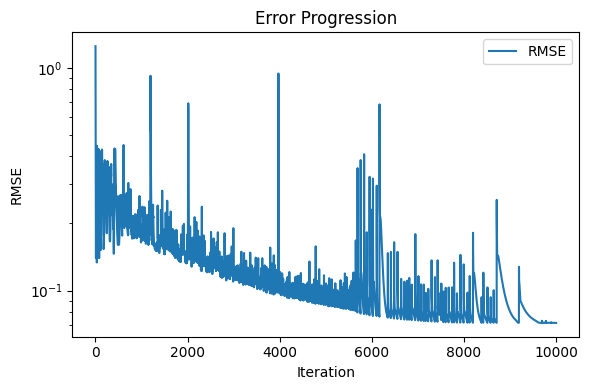

Final err: 0.07158096134662628


tensor([[ 7.5329e-01,  3.7025e-01,  2.5811e-01,  7.3117e-03,  1.1166e-02,
          4.2211e-04, -3.5689e+00],
        [ 4.3777e-01,  2.7459e-01,  2.2351e-01, -1.6304e-03,  9.7066e-01,
          2.2563e-01,  1.5067e+00],
        [ 5.3909e-01,  3.2731e-01,  2.2931e-01, -9.7050e-04,  9.9966e-01,
         -1.7299e-02, -1.1042e+01],
        [ 5.3695e-01,  3.2312e-01,  2.3646e-01, -3.7696e-02,  9.1871e-01,
         -2.2384e-01,  1.4743e+00],
        [ 4.6647e-01,  2.6924e-01,  2.3053e-01, -9.2299e-02,  7.6455e-01,
         -3.9918e-01,  1.3717e+00]], requires_grad=True)

In [10]:
from matplotlib import pyplot as plt
from tqdm import tqdm

rec = read_hands("dataset.rec")

y = normalize_hand(rec)

B, L = y.shape[0], y.shape[1]

morphology = torch.rand(5, 7, device=y.device, requires_grad=True)

optimizer = torch.optim.NAdam([morphology], lr=0.3)
scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer,
    start_factor=1.0,
    end_factor=0.01,
    total_iters=10000,
)

err_history = []
lr_history = []

for _ in tqdm(range(10000)):
    optimizer.zero_grad()
    y_hat = hand_landmarks_by_angles(
        inverse_hand_angles_by_landmarks(y, morphology), morphology
    )
    loss = ((y_hat - y) ** 2).sum(dim=-1).mean()

    loss.backward()
    optimizer.step()
    scheduler.step()

    err_history.append(loss.sqrt().item())
    lr_history.append(optimizer.param_groups[0]["lr"])

# Plot error progression
plt.figure(figsize=(6, 4))
plt.plot(err_history, label="RMSE")
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title(f"Error Progression")
plt.legend()
plt.tight_layout()
plt.show()

print("Final err:", err_history[-1])
morphology

In [15]:
from random import randint

i = randint(0, 1000)

plot_3d_hand(y[i])
plot_3d_hand(y_hat[i])